# House Prices - Advanced Regression Techniques

## Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

In [2]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Drop ID
train.drop(['Id'], axis=1, inplace=True)
test_id = test['Id']
test.drop(['Id'], axis=1, inplace=True)

In [4]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
# Create new feature TotalSF that is the total area of basement, 1st and 2nd floor areas
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

train['Qual_SF'] = train['OverallQual'] * train['TotalSF']
test['Qual_SF'] = test['OverallQual'] * test['TotalSF']

train = train.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'TotalSF'], axis=1)
test = test.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OverallQual', 'TotalSF'], axis=1)

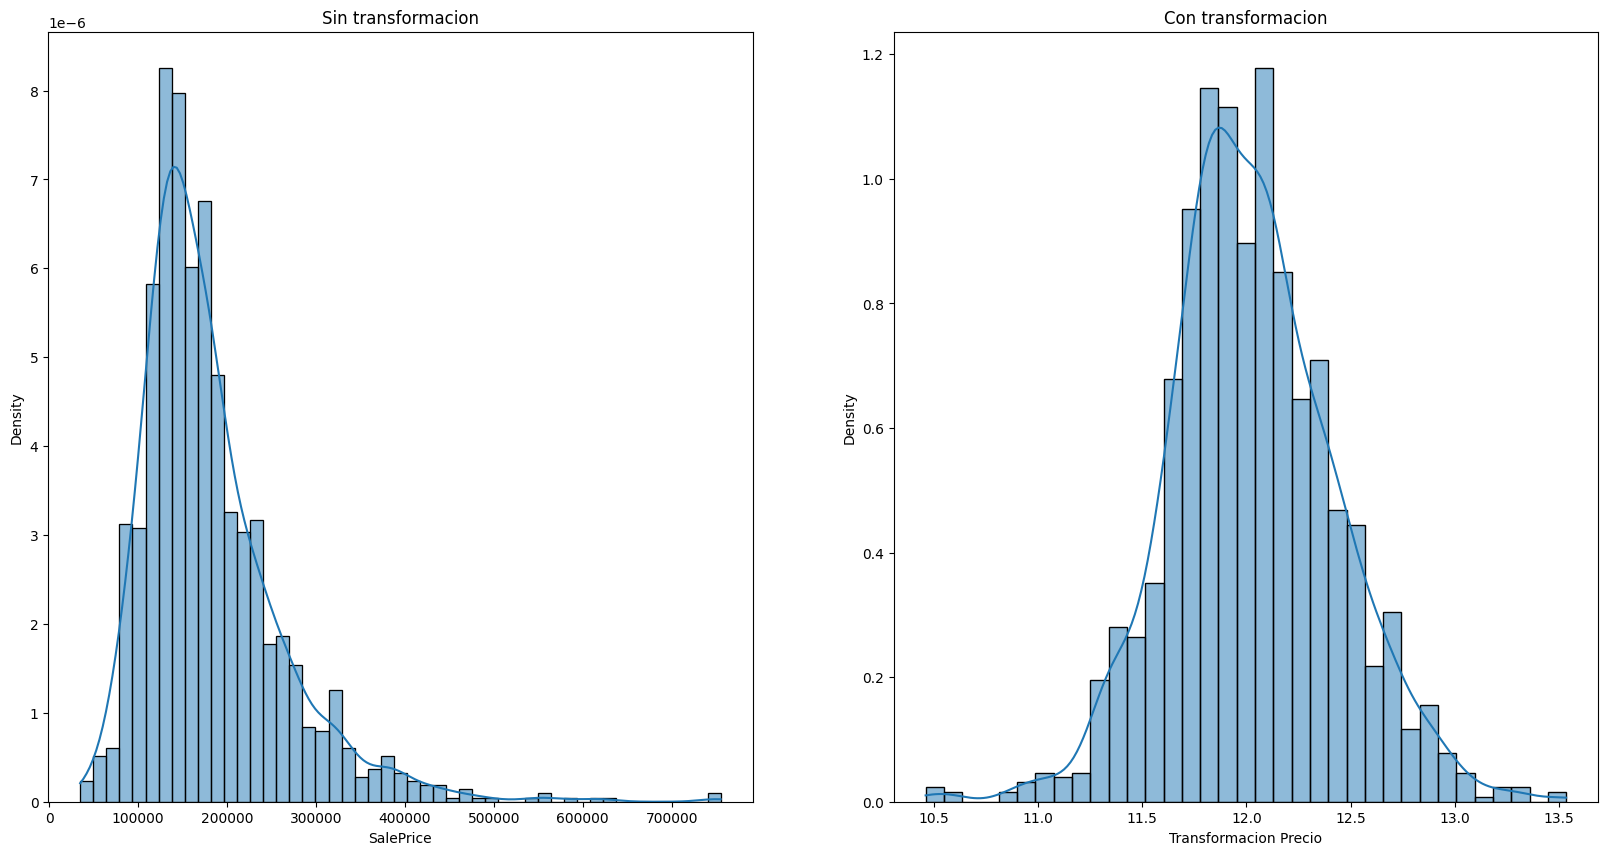

In [6]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True, stat="density")
plt.title('Sin transformacion')

plt.subplot(1, 2, 2)
sns.histplot(np.log(train['SalePrice']), kde=True, stat="density")
plt.xlabel('Transformacion Precio')
plt.title('Con transformacion')
plt.show()

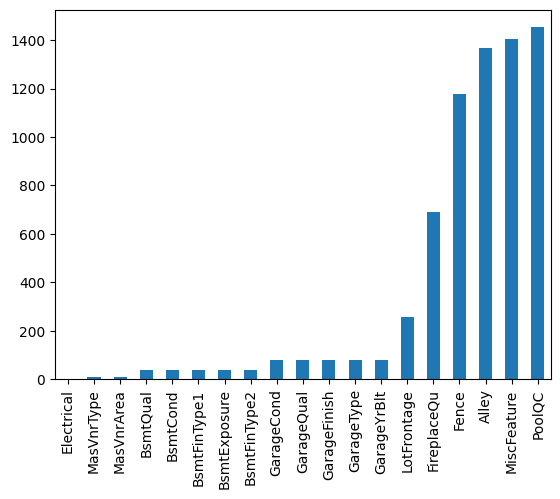

In [7]:
# Analyzing Missing Data
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
plt.show()

<ipython-input-8-df1bcf60d1d4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


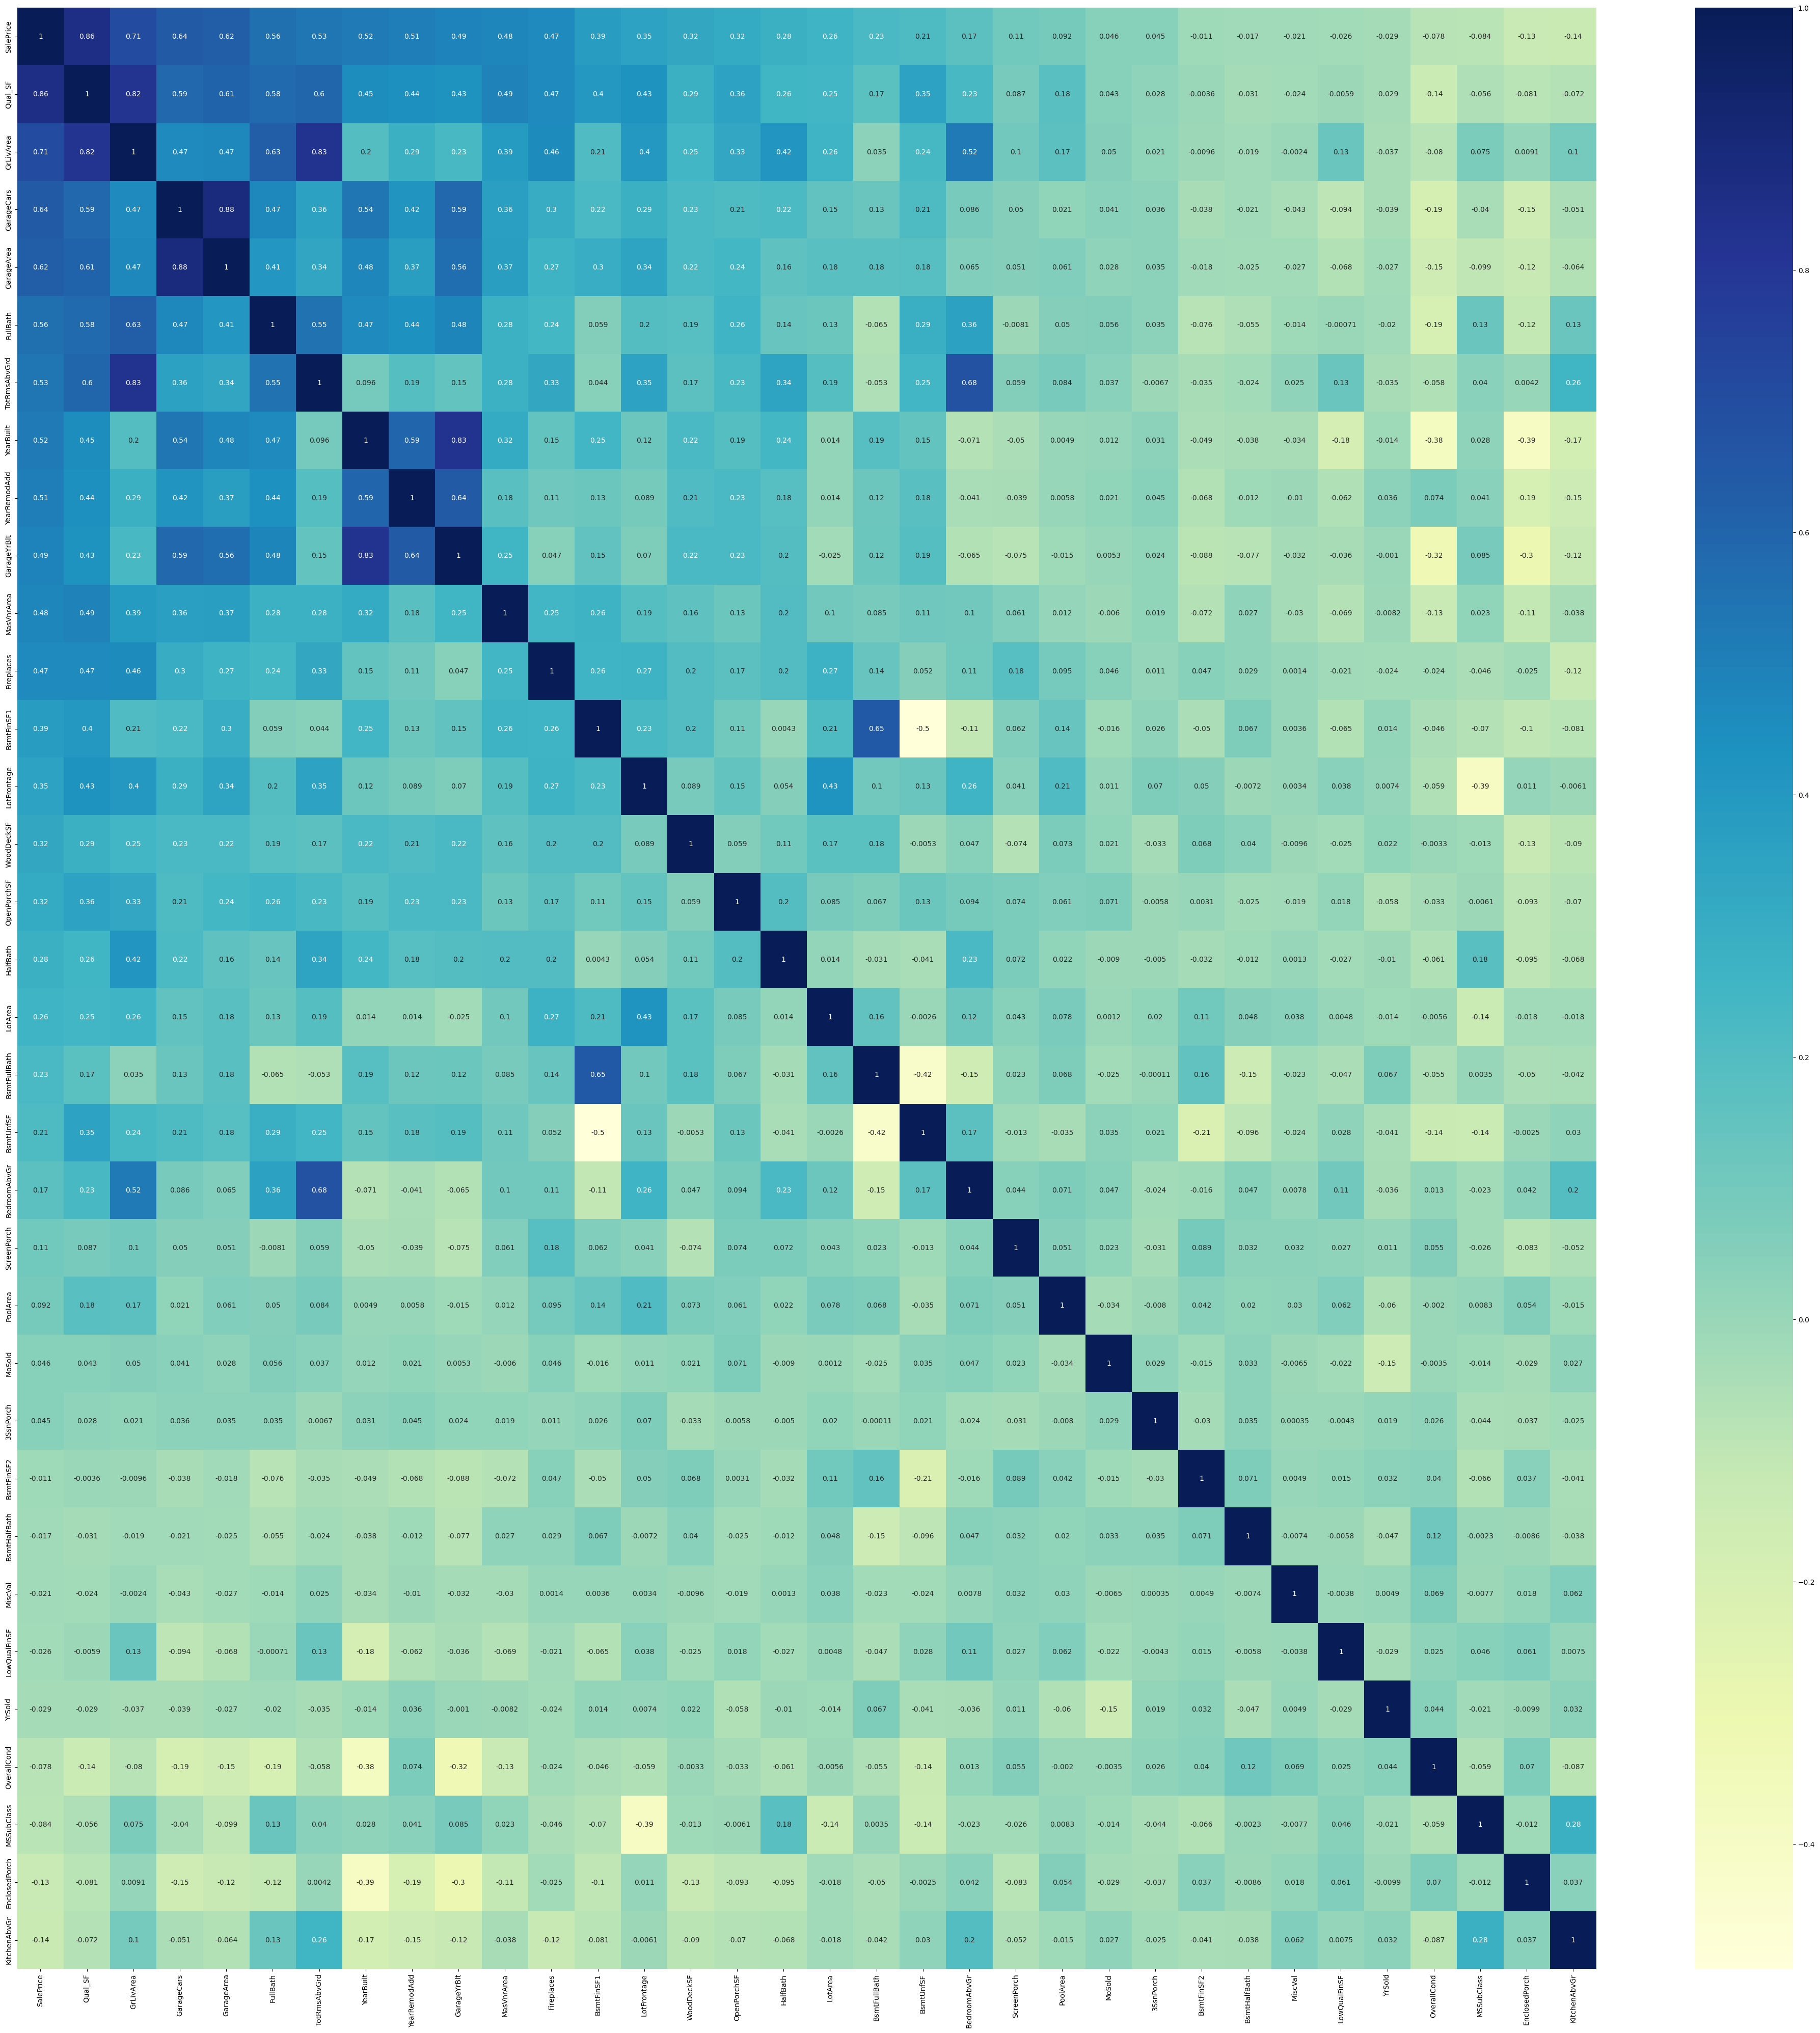

In [8]:
# Correlation analysis
corr = train.corr()

corr_organizado_Selling = corr['SalePrice'].sort_values(ascending=False)
cols = corr_organizado_Selling.index.tolist()

plt.figure(figsize=(50,50))
sns.heatmap(train[cols].corr(), annot=True, cmap='YlGnBu')
plt.show()

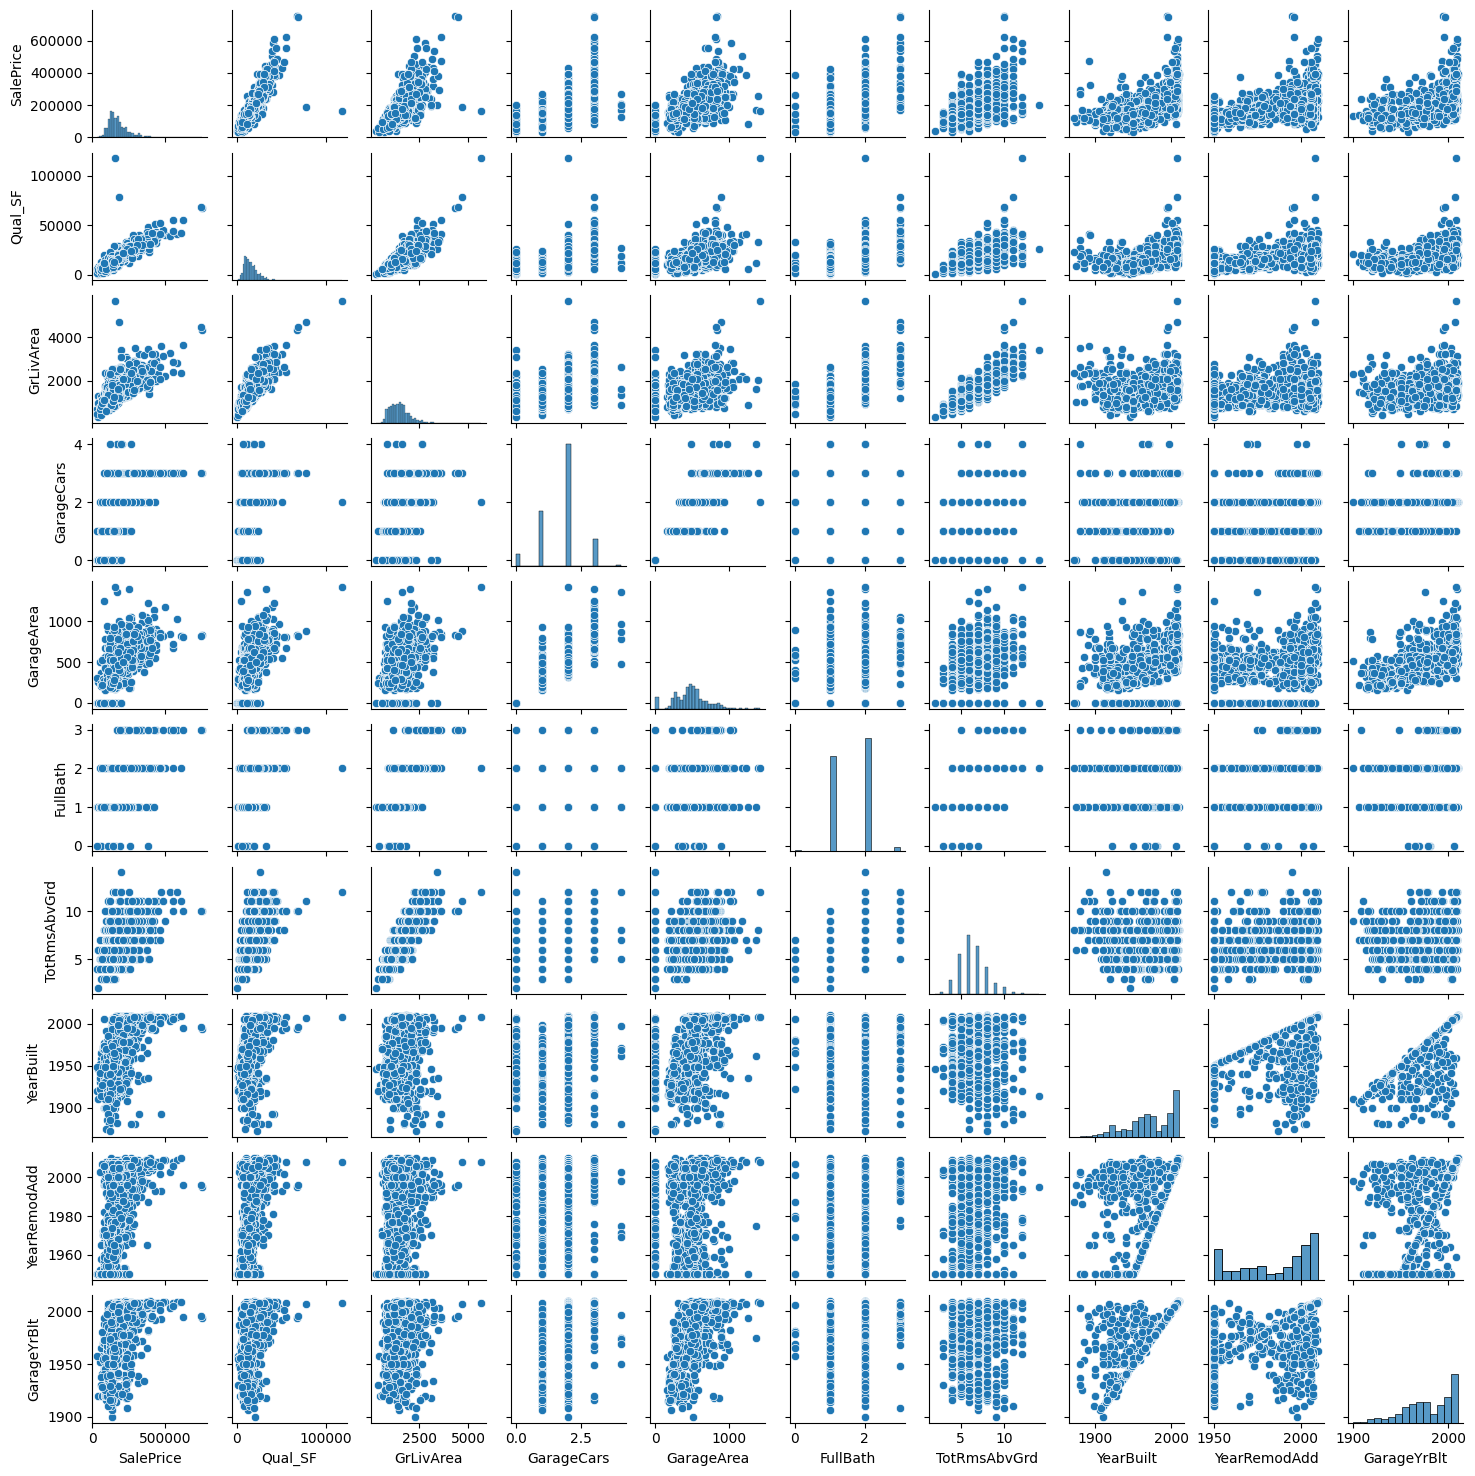

In [9]:
# Pairplot for top correlated variables
top_corr_cols = corr['SalePrice'].sort_values(ascending=False).head(10).index
sns.pairplot(train[top_corr_cols], height=1.5)
plt.show()

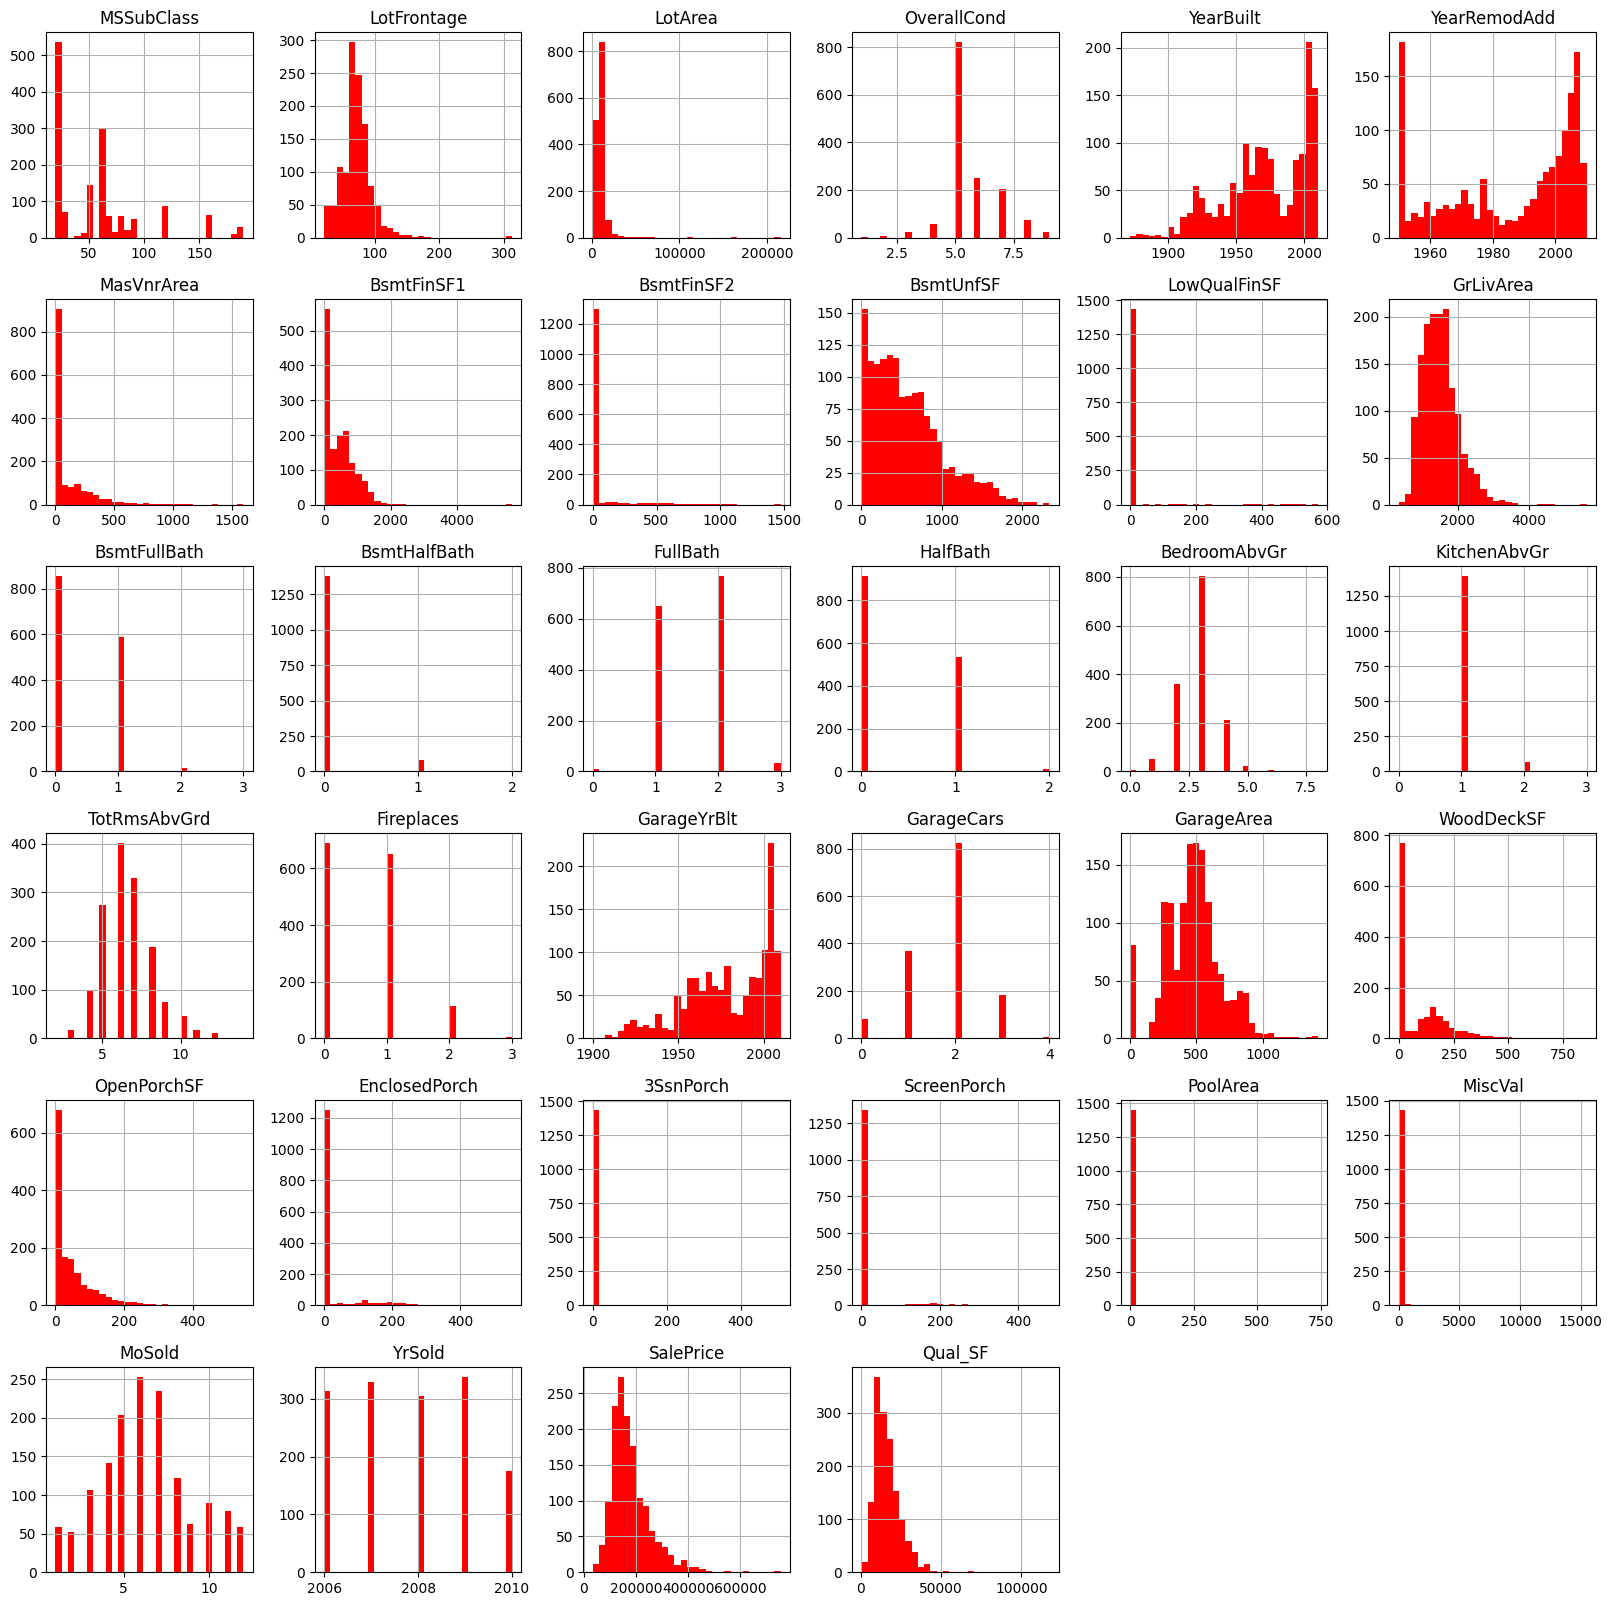

In [10]:
# Analyzing distributions of numerical features
train.hist(bins=30, figsize=(20,20), color='r')
plt.show()

## Data Preprocessing
We perform preprocessing for numerical and categorical data separately. For numerical data, we use K-Nearest Neighbors (KNN) imputation. For categorical data, we first impute missing values using the most frequent value, then apply One-Hot Encoding to transform categorical variables into a form that could be provided to machine learning algorithms to improve prediction.

In [11]:
# Separate target from predictors
y = train['SalePrice']
X = train.drop(['SalePrice'], axis=1)

# Log-transform the target variable
y = np.log(y)

In [12]:
# Select numerical and categorical features
numerical_cols = [cname for cname in X.columns if
                X[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() < 10 and
                    X[cname].dtype == "object"]

In [13]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define feature selection method
feature_selection = SelectFromModel(Lasso(alpha=0.005, random_state=0))

In [15]:
# Hyperparameters to tune for each of the models
params = {
    'lightgbm': {
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.1, 1],
    },
    'gbr': {
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.1, 1],
    },
    'xgboost': {
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.1, 1],
    },
    'rf': {
        'n_estimators': [100, 500, 1000],
    }
}

# Define models for stacking
estimators = [
    ('lightgbm', LGBMRegressor()),
    ('gbr', GradientBoostingRegressor()),
    ('xgboost', XGBRegressor()),
    ('rf', RandomForestRegressor())
]

# Split the dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# Apply preprocessing on X_train
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = feature_selection.fit_transform(X_train_preprocessed, y_train)

# Grid search for hyperparameters
for name, estimator in estimators:
    grid_search = GridSearchCV(estimator=estimator, param_grid=params[name], cv=5)
    grid_search.fit(X_train_preprocessed, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")

    # Replace the estimator in the stack with the best estimator from grid search
    for i in range(len(estimators)):
        if estimators[i][0] == name:
            estimators[i] = (name, grid_search.best_estimator_)

Best parameters for lightgbm: {'learning_rate': 0.01, 'n_estimators': 1000}
Best score for lightgbm: 0.890022319768789
Best parameters for gbr: {'learning_rate': 0.1, 'n_estimators': 500}
Best score for gbr: 0.8911217671000715
Best parameters for xgboost: {'learning_rate': 0.01, 'n_estimators': 1000}
Best score for xgboost: 0.8897344165904956
Best parameters for rf: {'n_estimators': 1000}
Best score for rf: 0.8768432647451357


In [17]:
# Create a stacking regressor
model = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(random_state=0))

# Bundle preprocessing, feature selection and modeling code in a pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('feature_selection', feature_selection),
                       ('model', model)
                     ])

## Model Training and Evaluation
We train our model using the training dataset and evaluate its performance on the validation dataset.

In [18]:
# Preprocessing and training
pipe.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = pipe.predict(X_valid)

print('R2:', r2_score(y_valid, preds))
print('RMSE:', np.sqrt(mean_squared_error(y_valid, preds)))

R2: 0.8448374891793237
RMSE: 0.1532696304062379


## Residual Analysis
Residuals are the differences between the actual and predicted values. We visualize the residuals to understand how well our model performed.

MSE : 0.0093 RMSE : 0.09643650760992954
R2 : 0.9417700551988084 Adjusted R2 : 0.9385701450000444


(0.0093, 0.09643650760992954, 0.9417700551988084, 0.9385701450000444)

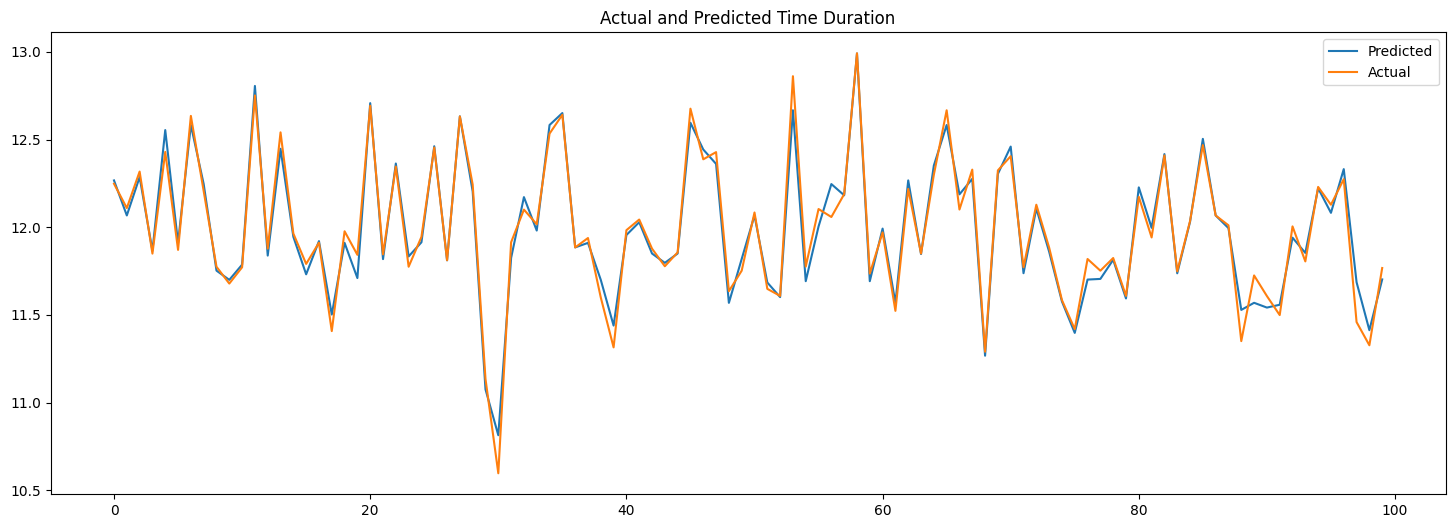

In [19]:
def EvaluationMetric(Xt,yt,yp,disp="on"):
    ''' Take the different set of parameter and prints evaluation metrics '''
    MSE=round(mean_squared_error(y_true=yt,y_pred=yp),4)
    RMSE=(np.sqrt(MSE))
    R2=(r2_score(y_true=yt,y_pred=yp))
    Adjusted_R2=(1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)))
    if disp=="on":
        print("MSE :",MSE,"RMSE :", RMSE)
        print("R2 :",R2,"Adjusted R2 :",Adjusted_R2)

    #Plotting Actual and Predicted Values
    plt.figure(figsize=(18,6))
    plt.plot((yp)[:100])
    plt.plot((np.array(yt)[:100]))
    plt.legend(["Predicted","Actual"])
    plt.title('Actual and Predicted Time Duration')

    return (MSE,RMSE,R2,Adjusted_R2)

EvaluationMetric(X,y,(pipe.predict(X)))

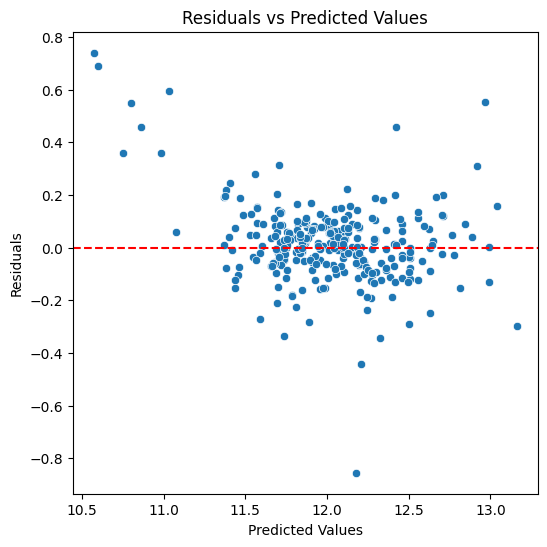

In [20]:
# Calculate residuals
residuals = y_valid - preds

# Scatter plot of predicted vs residuals
plt.figure(figsize=(6,6))
sns.scatterplot(x=preds, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

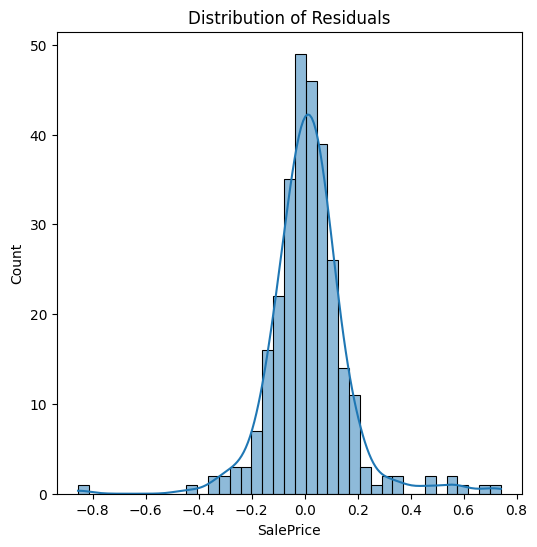

In [21]:
# Distribution of residuals
plt.figure(figsize=(6,6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

For our residuals:

* The test statistic is 519.7177573380284
* The p-value is 1.3954777633294462e-113

The p-value is less than 0.05, which is a commonly used threshold for significance in statistical hypothesis testing. Therefore, we reject the null hypothesis that the residuals are normally distributed. This indicates that the model might not be capturing some information from the data, or certain assumptions of the model might be violated.

In [22]:
# Preprocessing of test data, fit model
preds_test = pipe.predict(test)

# The target variable was log-transformed, so we need to exponentiate the predictions
preds_test = np.exp(preds_test)

# Save test predictions to file
output = pd.DataFrame({'Id': test_id,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)